In [1]:
#pip install reportlab
import json
import glob
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import itertools
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import random

In [3]:
with open('dataset.json', 'r') as file:
    data = json.load(file)

print(data)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [16]:
# look at json
# multiple labels per restaurant
for i in range(20):
    print(i)
    labels = [d['label'] for d in data[i]['cuisines']]
    print(labels)

0
['Greek']
1
['Modern French']
2
['Seafood']
3
['Modern French']
4
['Seafood', 'Classic Cuisine']
5
['Seafood']
6
['Organic', 'Market Cuisine']
7
['Japanese']
8
['Belgian', 'Classic Cuisine']
9
['Classic Cuisine', 'Belgian']
10
['Classic French']
11
['Belgian', 'Classic Cuisine']
12
['Classic Cuisine']
13
['Modern French', 'Creative']
14
['Traditional Cuisine', 'Belgian']
15
['Creative']
16
['Italian']
17
['Belgian']
18
['Seasonal Cuisine', 'Belgian']
19
['Seasonal Cuisine']


In [17]:
# extract image IDs of one restaurant
one_restaurant_info=data[0]['more_details']['full_images']
one_restaurant_images=[i['image_id'] for i in one_restaurant_info]
one_restaurant_images

['2088757', '2182000', '4151606', '4151588', '2224983']

In [18]:
# do this for all restaurants
import random
res_image_dic={}
cuisine_dic={}
for res in data:
    # use cuisine type as restaurant 
    res_id= res['identifier']
    one_restaurant_info=res['more_details']['full_images']
    one_restaurant_images=[i['image_id'] for i in one_restaurant_info]
    if len(one_restaurant_images)!=0:
    # select 1 images per restaurant, otherwise too many images
        selected= one_restaurant_images[-1]#random.choices(one_restaurant_images,k=1)
    res_image_dic[res_id]=selected
    cuisine_dic[res_id] = [d['label'] for d in res['cuisines']]

In [21]:
# get all cuisine names
flat_list = [item for sublist in cuisine_dic.values() for item in sublist]
flat_list

['Greek',
 'Modern French',
 'Seafood',
 'Modern French',
 'Seafood',
 'Classic Cuisine',
 'Seafood',
 'Organic',
 'Market Cuisine',
 'Japanese',
 'Belgian',
 'Classic Cuisine',
 'Classic Cuisine',
 'Belgian',
 'Classic French',
 'Belgian',
 'Classic Cuisine',
 'Classic Cuisine',
 'Modern French',
 'Creative',
 'Traditional Cuisine',
 'Belgian',
 'Creative',
 'Italian',
 'Belgian',
 'Seasonal Cuisine',
 'Belgian',
 'Seasonal Cuisine',
 'Spanish',
 'Seafood',
 'Italian',
 'Sicilian',
 'Belgian',
 'Traditional Cuisine',
 'Classic Cuisine',
 'Country cooking',
 'Asian Influences',
 'Creative',
 'Modern Cuisine',
 'International',
 'Traditional Cuisine',
 'Classic French',
 'Italian',
 'Vietnamese Contemporary',
 'Meats and Grills',
 'Modern French',
 'Regional Cuisine',
 'Classic Cuisine',
 'Market Cuisine',
 'Traditional Cuisine',
 'Cuisine from South West France',
 'Country cooking',
 'French',
 'Italian',
 'Organic',
 'Vegetarian',
 'Vegetarian',
 'Organic',
 'Modern Cuisine',
 'Creati

In [33]:
from collections import Counter

counter = Counter(flat_list)

df = pd.DataFrame(list(counter.items()), columns=['Element', 'Count'])

# Sort the DataFrame by count in descending order
df = df.sort_values(by=['Count'], ascending=False)

# Reset the index
df = df.reset_index(drop=True)

# look at the most frequently appearing types
df.iloc[:30,:]

,Element,Count
0,Modern Cuisine,3764
1,Traditional Cuisine,1381
2,Creative,1225
3,Contemporary,1076
4,Market Cuisine,746
5,Seafood,734
6,Italian,725
7,Classic Cuisine,687
8,Japanese,659
9,Country cooking,639


In [62]:
country_tags= [ #'Modern Cuisine',
#  'Traditional Cuisine',
#  'Creative',
#  'Contemporary',
#  'Market Cuisine',
#  'Seafood',
 'Italian',
#  'Classic Cuisine',
 'Japanese',
#  'Country cooking',
#  'Mediterranean Cuisine',
#  'International',
#  'Regional Cuisine',
 'French',
  'Modern British',
#  'Street Food',
#  'Modern French',
#  'Seasonal Cuisine',
#  'Cantonese',
#  'American',
#  'Sushi',
#  'Classic French',
 'Chinese',
  'Thai',
#  'Fusion',
#  'Italian Contemporary',
#  'French Contemporary',
 'Indian',
#  'Meats and Grills',
 'Mexican']

In [63]:
# filter restaurant ID that corresponds to the tag above 
# Filter the keys in the dictionary whose items are in the list
filtered_dict = {k: v for k, v in cuisine_dic.items() if any(elem in v for elem in country_tags)}

# Convert the filtered dictionary to a DataFrame
filtered_restaurant=pd.DataFrame.from_dict(filtered_dict, orient='index')#, columns=['Cuisine'])
filtered_restaurant.columns=['tag1','tag2']
filtered_restaurant
# in some cases, a restaurant has two tags, two similar country cuisines

,tag1,tag2
113876,Japanese,None
504797,Italian,None
477155,Italian,Sicilian
1201928,Italian,None
566485,French,None
...,...,...
524772,Italian,None
436301,Japanese,None
417338,French,None
485984,Japanese,Korean


In [103]:
filtered_restaurant_single_tag=filtered_restaurant[filtered_restaurant['tag2'].isna()].reset_index()
filtered_restaurant_single_tag.head()

,index,tag1,tag2
0,113876,Japanese,None
1,504797,Italian,None
2,1201928,Italian,None
3,566485,French,None
4,457944,Italian,None


In [130]:
# classes are somewhat imbalanced
filtered_restaurant_single_tag.groupby('tag1').count()

#could just choose the classes that are more balanced: French, Italian, Japense, Modern British


,index,tag2,image_id
tag1,,,
Chinese,99,0,99
French,311,0,311
Indian,111,0,111
Italian,436,0,436
Japanese,450,0,450
Mexican,58,0,58
Modern British,339,0,339
Thai,166,0,166


In [104]:
restaurant_id_selected =list(filtered_restaurant_single_tag['index'])

In [107]:
image_names = [res_image_dic[k] for k in restaurant_id_selected]
#image_names

filtered_restaurant_single_tag['image_id']=image_names
#filtered_restaurant_single_tag

image_id_label=filtered_restaurant_single_tag.set_index('image_id')['tag1'].to_dict()
image_id_label

{'1955140': 'Japanese',
 '1956974': 'Italian',
 '4609070': 'Italian',
 '1911250': 'French',
 '4152648': 'Italian',
 '4668524': 'Italian',
 '2146157': 'Italian',
 '5611627': 'Italian',
 '2221633': 'Italian',
 '5489548': 'French',
 '2254872': 'Italian',
 '2298149': 'Italian',
 '4961770': 'Italian',
 '2051604': 'Italian',
 '2251131': 'Italian',
 '2191687': 'Italian',
 '4493783': 'Italian',
 '1908528': 'Italian',
 '2040600': 'Thai',
 '2260291': 'Chinese',
 '1958831': 'Italian',
 '2090936': 'Italian',
 '1955743': 'Italian',
 '5030848': 'Italian',
 '5471558': 'Thai',
 '1955875': 'Italian',
 '5320439': 'Italian',
 '4829194': 'Italian',
 '2694413': 'Italian',
 '2218429': 'Italian',
 '4971864': 'Chinese',
 '2156007': 'Chinese',
 '2280804': 'Japanese',
 '2142853': 'Thai',
 '4575262': 'Italian',
 '2247280': 'French',
 '2141684': 'Chinese',
 '2181089': 'Italian',
 '2117355': 'Italian',
 '4210301': 'Italian',
 '2281150': 'Italian',
 '1955330': 'Japanese',
 '5439551': 'French',
 '4670402': 'Italian'

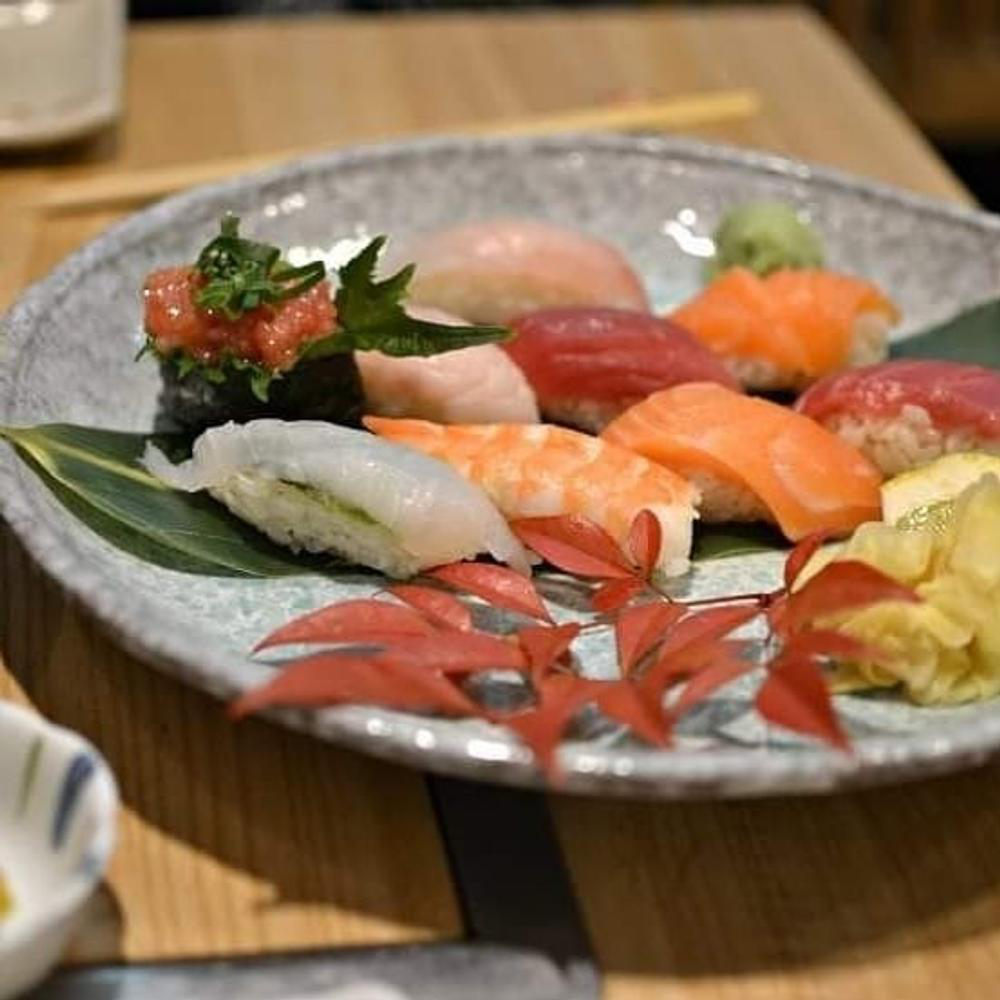

In [78]:
# test reading an image
folder_path = '/Users/wentingjiang/Downloads/assignment2/images'
image_path=folder_path + '/' + image_names[0] + '.jpg'
img=Image.open(image_path)
img

In [88]:
# reading all images in a restaurant setting  (for relevant cuisines)
all_images={}
folder_path = '/Users/wentingjiang/Downloads/assignment2/images'
#target_size = (256, 256) # need to resize because some images do not have the same shap
target_size = (64, 64) # use smaller size to make computation more efficient

for name in image_names:
    file_name=name + '.jpg'
    image_path = folder_path + '/' + file_name
    try:
        with Image.open(image_path) as img:
            img = img.resize(target_size)
            image_array = np.array(img)
            if image_array.shape == (64, 64, 3):
                all_images[name]=image_array
            #print(name)
    except:
        print(f"Error opening file '{file_name}', skipping...")
        continue

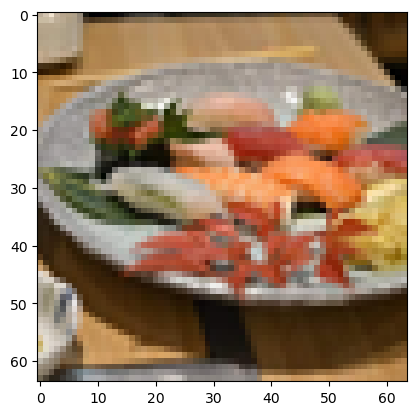

In [93]:
plt.imshow(all_images['1955140'], cmap='gray')
plt.show() # quality of 64x64 becomes much worse

In [108]:
test_image_list=[]
test_image_names=[]
test_labels=[]
for i in all_images: 
    test_image_list.append(all_images[i])
    test_image_names.append(i)
    test_labels.append(image_id_label[i])

In [109]:
test=np.array(test_image_list)
test.shape

(1948, 64, 64, 3)

# Not filtering food images, just fit cuisine model directly

In [100]:
import keras

In [111]:
final_labels= test_labels.copy()

In [112]:
from sklearn import preprocessing
  
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
# Encode labels in column 'species'.
final_labels_int= label_encoder.fit_transform(final_labels)

In [117]:
class_cat=pd.DataFrame(final_labels)
class_cat.columns=['label']
dummies = pd.get_dummies(class_cat.label)
dummies.shape

(1948, 8)

# Modelling

In [118]:
X = test.copy() 
y = np.array(dummies)
#y = np.array(final_labels_int)

In [120]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, final_labels_int, test_size=0.2, stratify=y, random_state=42)

In [123]:
import functools
#https://stackoverflow.com/questions/51951358/keras-how-to-get-top-k-accuracy
top3_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=3)
top3_acc.__name__ = 'top3_acc'

In [127]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.applications import VGG16

from tensorflow.keras.layers import Dropout


# Load the pre-trained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze pre-trained layers (compare with no freezing)
for layer in base_model.layers:
    layer.trainable = False

# Define your own classification layers
model = Sequential()
model.add(base_model)
model.add(Dropout(0.2)) # avoid overfitting
model.add(Flatten())


#model.add(Dense(128, activation='relu'))

#val acc>0.2
model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.2)) # adding it twuice to avoid overfitting
model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.2)) # adding it twuice to avoid overfitting

model.add(Dense(8, activation='softmax'))
#https://datascience.stackexchange.com/questions/39264/how-does-sigmoid-activation-work-in-multi-class-classification-problems

# Compile the model
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy','top_k_categorical_accuracy',top3_acc])

#sparse_categorical_crossentropy

In [128]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 dropout_3 (Dropout)         (None, 2, 2, 512)         0         
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_9 (Dense)             (None, 64)                131136    
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 8)                 520       
                                                                 
Total params: 14,850,504
Trainable params: 135,816
Non

In [129]:
# Train the model
#model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))


# Evaluate the model on test set
score = model.evaluate(X_test, y_test)
print('Test accuracy:', score[1])

Epoch 1/10
98/98 [==============================] - 23s 229ms/step - loss: 6.8311 - accuracy: 0.1996 - top_k_categorical_accuracy: 0.3273 - top3_acc: 0.1412 - val_loss: 3.1226 - val_accuracy: 0.1897 - val_top_k_categorical_accuracy: 0.4000 - val_top3_acc: 0.1667
Epoch 2/10
98/98 [==============================] - 23s 238ms/step - loss: 2.4152 - accuracy: 0.2978 - top_k_categorical_accuracy: 0.3440 - top3_acc: 0.1374 - val_loss: 2.3040 - val_accuracy: 0.2436 - val_top_k_categorical_accuracy: 0.2462 - val_top3_acc: 0.0923
Epoch 3/10
98/98 [==============================] - 24s 250ms/step - loss: 1.8460 - accuracy: 0.3485 - top_k_categorical_accuracy: 0.2490 - top3_acc: 0.0757 - val_loss: 2.1839 - val_accuracy: 0.2282 - val_top_k_categorical_accuracy: 0.2897 - val_top3_acc: 0.1256
Epoch 4/10
98/98 [==============================] - 33s 336ms/step - loss: 1.6824 - accuracy: 0.3896 - top_k_categorical_accuracy: 0.3678 - top3_acc: 0.1425 - val_loss: 2.2096 - val_accuracy: 0.2026 - val_top_k_

In [ ]:
# Filter filter out non-food images, and then fit a new model